# **Tools in LangGraph:**

In LangGraph, tools are external functions or actions that can be executed as part of a graph's workflow. They enable the model to perform specific tasks, such as arithmetic operations, interacting with APIs, or executing custom Python functions, instead of relying solely on language generation. Tools allow the model to extend its capabilities beyond simple text completion, making it versatile for various use cases, including custom logic and dynamic execution during a conversation.

## **Install Packages:**

In [ ]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

## **Import Gemini Key:**

In [ ]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

## **Define Model:**

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

## **Define A Custom Tool:**

Let's create a custom tool for multiplication (multiply(a: int, b: int)), and bind it to the model using the Gemini API. This tool can be invoked during the conversation based on user input, allowing the model to shift from natural language generation to executing a function.

In [1]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

## **Bind The Custom Tool With Our Model:**

The Gemini model can now call the multiply function when the conversation context demands arithmetic. This is a key part of enhancing the model's functionality with custom logic.

In [ ]:
llm_with_tools = gemini_flash.bind_tools([multiply])

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

## **User Messages As A State:**

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

## **Create Node:**

Defines the core node that calls the Gemini model with tools. The node takes the current conversation state, calls the model (which includes custom tools like multiply), and returns the updated message list.

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

def tool_calling_llm(state:MessagesState):
    return {"messages":llm_with_tools.invoke(state['messages'])}

## **Build The Graph:**

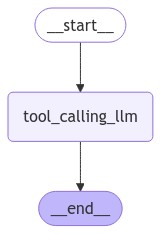

In [ ]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Build the graph
builder:StateGraph = StateGraph(MessagesState)

# Add the node that calls the Gemini model with tools
builder.add_node("tool_calling_llm", tool_calling_llm)

# Define the flow of the conversation
builder.add_edge(START, "tool_calling_llm")  # Start with the tool-calling node
builder.add_edge("tool_calling_llm", END)    # End the conversation after generating a response

# Compile the graph
graph:CompiledStateGraph = builder.compile()

# Display the graph structure as a diagram
display(Image(graph.get_graph().draw_mermaid_png()))

## **Invoke The Graph:**

Let's invoke the graph with a simple conversation

In [ ]:
from pprint import pprint
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

messages = graph.invoke({"messages":HumanMessage(content="Hello there, What's up")})

for m in messages['messages']:
    m.pretty_print()

{'name': 'multiply', 'description': 'Multiply two numbers.', 'parameters': {'type_': 6, 'description': 'Multiply two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================ Human Message =================================

Hello there, What's up
================================== Ai Message ==================================

Hello! Not much, just hanging out in the digital world, waiting to answer your questions. What about you? 😊




The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.


In [ ]:
messages = graph.invoke({"messages":HumanMessage(content="Multiply 15 and 8")})
for m in messages['messages']:
    m.pretty_print()

{'name': 'multiply', 'description': 'Multiply two numbers.', 'parameters': {'type_': 6, 'description': 'Multiply two numbers.', 'properties': {'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
================================ Human Message =================================

Multiply 15 and 8
================================== Ai Message ==================================
Tool Calls:
  multiply (c573a3fe-1e54-4b96-8012-1dc008f6255d)
 Call ID: c573a3fe-1e54-4b96-8012-1dc008f6255d
  Args:
    b: 8.0
    a: 15.0
